FUZZY ASSOCIATIVE MEMORIES

FAMs are a technique of fuzzy system mapping input to output, using the rule IF-THEN: B = A . R

For the nonlinear function y = 10 sin x1, we will develop a fuzzy rule-based system using four simple fuzzy rules to approximate the output y. The universe of discourse for the input variable x1 will be the interval [-180°, 180°], and the universe of discourse for the output variable y is the interval [-10, 10].

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def trimf(
    x: np.ndarray,
    a: float,
    b: float,
    c: float
) -> np.array:
    """
    Triangular matrix for input x output

    Args
    -------
    x: np.ndarray
        Array with universe points
    a: Left limit (membership = 0)
    b: Central point (membership = 1)
    c: Right limit (membership = 0)

    Returns
    ----------
    np.ndarray: Membership relation for each point
    """
    if a >= b or b >= c:
        raise ValueError("The parameters must satisfy a < b < c")

    y = np.zeros_like(x, dtype=float)
    
    mask_ab = (x >= a) & (x <= b)
    y[mask_ab] = (x[mask_ab] - a) / (b - a)

    mask_bc = (x >= b) & (x <= c)
    y[mask_bc] = (c - x[mask_bc]) / (c - b)

    return y

In [3]:
def trapmf(
    x: np.ndarray,
    a: float,
    b: float,
    c: float,
    d: float
) -> np.array:
    """
    Trapezoidal matrix for input x output

    Args
    ---------
    x: np.ndarray
        Array with universe points
    a: Start of the crescent segment limit
    b: Flat region start (membership reaches 1)
    c: Flat region end
    d: End of the decrescent segment limit

    Returns
    ---------------
    np.ndarray: Membership relation for each point
    """
    if a > b or b >= c or c > d:
        raise ValueError("The parameters must satisfy a < b < c < d")
    
    y = np.zeros_like(x, dtype=float)
    
    if a < b and c < d:
        mask_ab = (x >= a) & (x <= b)
        if b != a:
            y[mask_ab] = (x[mask_ab] - a) / (b - a)
        else:
            y[mask_ab] = 1.0
        
        mask_bc = (x >= b) & (x <= c)
        y[mask_bc] = 1.0
        
        mask_cd = (x >= c) & (x <= d)
        if d != c:
            y[mask_cd] = (d - x[mask_cd]) / (d - c)
        else:
            y[mask_cd] = 1.0
    
    elif a == b:
        mask_flat = (x >= a) & (x <= c)
        y[mask_flat] = 1.0
        
        if c < d:
            mask_dec = (x > c) & (x <= d)
            y[mask_dec] = (d - x[mask_dec]) / (d - c)
    
    elif c == d:
        if a < b:
            mask_inc = (x >= a) & (x < b)
            y[mask_inc] = (x[mask_inc] - a) / (b - a)
        
        mask_flat = (x >= b) & (x <= c)
        y[mask_flat] = 1.0
    
    else:
        mask = (x >= a) & (x <= d)
        y[mask] = 1.0
    
    return y

In [4]:
# membership matrix (R)
def membership_matrix(
    inputs: list,
    outputs: list,
    x_universe: np.ndarray,
    y_universe: np.ndarray,
    if_then_operator: str = 'min',
) -> np.ndarray:
    """
    Creates the fuzzy membership matrix R

    Args
    --------------
    inputs: array with input memberships
    outputs: array with output memberships
    x_universe: input variable discourse
    y_universe: output variable discourse
    if_then_operator: 
        'min' -> Mandani
        'prod' -> Larsen

    Returns
    -----------
    np.ndarray: Fuzzy membership matrix 
    """

    n_x = len(x_universe)
    n_y = len(y_universe)
    R = np.zeros((n_x, n_y))

    for A, B in zip(inputs, outputs):
        for i in range(n_x):
            for j in range(n_y):
                if if_then_operator == 'min':
                    value = min(A[i], B[j])
                else:  # 'prod'
                    value = A[i] * B[j]
                
                R[i, j] = max(R[i, j], value)

    return R

In [5]:
def fuzzy_inference(
    x_value: float,
    x_universe: np.ndarray,
    R: np.ndarray,
    y_universe: np.ndarray
) -> np.ndarray:
    """
    Executes fuzzy inference using max-min composition

    Args
    -------
    x_value: input data
    x_universe: input variable discourse
    R: fuzzy membership function
    y_universe: output variable discourse

    Returns
    ----------
    np.ndarray: Fuzzy set result
    """

    idx = np.argmin(np.abs(x_universe - x_value))
    A = np.zeros(len(x_universe))
    A[idx] = 1.0
    B = np.zeros(len(y_universe))

    for i in range(len(y_universe)):
        max_value = 0
        for j in range(len(x_universe)):
            min_value = min(A[j], R[j, i])
            max_value = max(max_value, min_value)
        B[i] = max_value

    return B

In [6]:
def defuzzy_methods(
    B: np.ndarray,
    y_universe: np.ndarray,
    method: str = 'centroid'
) -> float:
    """
    Converts a fuzzy set B in a crisp value

    Args
    ---------
    B: Fuzzy set
    y_universe: output variable discourse
    method:
        'centroid': area center
        'bisector': area bisector
        'mom': mean of maximum
        'som': smalles of maximum
        'lom': largest of maximum

    Returns
    --------------
    Defuzzy crisp value
    """

    if method == 'centroid':
        num = np.sum(B * y_universe)
        den = np.sum(B)
        return num / den

    elif method == 'bisector':
        total_area = np.sum(B)
        accumulated_area = 0
        for i, b in enumerate(B):
            accumulated_area += b
            if accumulated_area >= total_area / 2:
                return y_universe[i]

    elif method in ['mom', 'som', 'lom']:
        max_value = np.max(B)
        idx_max = np.where(B == max_value)[0]

        if method == 'mom':
            return np.mean(y_universe[idx_max])
        elif method == 'som':
            return y_universe[idx_max[0]]
        else:
            return y_universe[idx_max[-1]]

    else:
        raise ValueError(f"Unrecognized method")

In [7]:
class FuzzySystem:

    """
    Main class from Fuzzy System
    Implementing FAM (Fuzzy Associative Memory)
    """

    def __init__(
        self,
        x_range: tuple = (-180, 180),
        y_range: tuple = (-10, 10),
        x_n: int = 1_000,
        y_n: int = 200
    ):

        """
        Initialization of the Fuzzy System

        Args
        -----------
        x_range: input variable interval (min, max)
        y_range: output variable interval (min, max)
        x_n: numbers of points in the x universe
        y_n: numbers of points in the y universe
        """

        self.x_universe = np.linspace(
            x_range[0], x_range[1], x_n
        )
        self.y_universe = np.linspace(
            y_range[0], y_range[1], y_n
        )

        self.R = None
        self.inputs = list()
        self.outputs = list()
        self.rules = list()

        self.create_fuzzy_sets()

    def create_fuzzy_sets(
        self,
    ) -> None:
        
        """
        Creates a pattern fuzzy set
        """

        x = self.x_universe
        y = self.y_universe

        self.inputs = [
            trapmf(x, -180, -180, -135, -90),
            trimf(x, -135, -90, -45),
            trimf(x, -90, -45, 0),
            trimf(x, -45, 0, 45),
            trimf(x, 0, 45, 90),
            trimf(x, 45, 90, 135),
            trapmf(x, 90, 135, 180, 180)
        ]

        self.outputs = [
            trapmf(y, -10, -10, -7.5, -5),
            trimf(y, -7.5, -5, -2.5),
            trimf(y, -5, -2.5, 0),
            trimf(y, -2.5, 0, 2.5),
            trimf(y, 0, 2.5, 5),
            trimf(y, 2.5, 5, 7.5),
            trapmf(y, 5, 7.5, 10, 10)
        ]

        self.rules = [(0, 3), (1, 1), (2, 2), (3, 3),
                      (4, 4), (5, 5), (6, 3)]

    def add_rule(
        self,
        input_idx: int,
        output_idx: int
    ) -> None:
        
        """
        Add a rule to the system

        Args
        --------
        input_idx: idx from the fuzzy set input
        output_idx: idx from the fuzzy set output
        """

        if (input_idx < 0 or input_idx >= len(self.inputs) or \
            output_idx < 0 or output_idx >= len(self.outputs)):
            raise IndexError("Idx out of the limits")

        self.rules.append((input_idx, output_idx))

    def building_membership_matrix(
        self,
        operator: str = 'min'
    ) -> None:
        
        """
        Builds the membership matrix with the rules
        """

        input_rules = list()
        output_rules = list()

        for idx_a, idx_b in self.rules:
            input_rules.append(self.inputs[idx_a])
            output_rules.append(self.outputs[idx_b])

        self.R = membership_matrix(
            input_rules, output_rules,
            self.x_universe, self.y_universe, operator
        )

    def inference(
        self,
        x_value: float,
        defuzzy_method: str = 'centroid',
    ) -> float:

        """
        Execute complete fuzzy inference

        Args
        ----------
        x_value: Crisp input value
        defuzzy_method: Used defuzzy method

        Returns
        ---------
        Crips output value
        """

        if self.R is None:
            raise ValueError("R matrix was not built")

        B = fuzzy_inference(
            x_value, self.x_universe, self.R, self.y_universe
        )

        return defuzzy_methods(B, self.y_universe, defuzzy_method)

    def checking_errors(
        self,
        real_function: callable,
        n_points: int = 100
    ) -> dict:

        """
        Check the fuzzy system error comparing with a real function
        
        Args
        ---------
        real_function: lambda function
        n_points: number of points to evaluate

        Returns
        ------------
        'mae': Mean Absolute Error
        'rmse': Sqrt Mean Squared Error 
        'max_error': Maximum error
        'points': Tested points
        'y_real': Real values
        'y_fuzzy' Fuzzy values
        """

        x_test = np.linspace(
            self.x_universe[0], self.x_universe[-1], n_points
        )

        y_real = np.array([real_function(x_i) for x_i in x_test])
        y_fuzzy = np.array([self.inference(x_i) for x_i in x_test])
        
        error = np.abs(y_real - y_fuzzy)

        return {
            'mae': np.mean(error),
            'rmse': np.sqrt(np.mean(error ** 2)),
            'max_error': np.max(error),
            'points': x_test,
            'y_real': y_real,
            'y_fuzzy': y_fuzzy
        }

    def plot_comparison(
        self,
        real_function: callable
    ) -> None:

        """
        Plot the result comparison

        Args
        ----------
        real_function: Real function to be callable
        """

        result = self.checking_errors(real_function)
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        axes[0].plot(result['points'], result['y_real'], 'b-', 
                    linewidth=2, label='Real function')
        axes[0].plot(result['points'], result['y_fuzzy'], 'r--', 
                    linewidth=2, label='Fuzzy System')
        axes[0].set_xlabel('x₁ (degress)')
        axes[0].set_ylabel('y')
        axes[0].set_title('Fuzzy vs Real')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        erro = np.abs(result['y_real'] - result['y_fuzzy'])
        axes[1].plot(result['points'], erro, 'g-', linewidth=2)
        axes[1].fill_between(result['points'], 0, erro, alpha=0.3, color='green')
        axes[1].set_xlabel('x₁ (degrees)')
        axes[1].set_ylabel('Absolute error')
        axes[1].set_title(f'Erro da Aproximação (MAE = {result["mae"]:.3f})')
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

In [8]:
def real_function(
    x: np.array
) -> np.array:

    """
    Our function from the problem

    Args
    ----------
    x: input data

    Return:
    ------------
    np.ndarray: Results from the function
    """

    return 10 * np.sin(np.deg2rad(x))

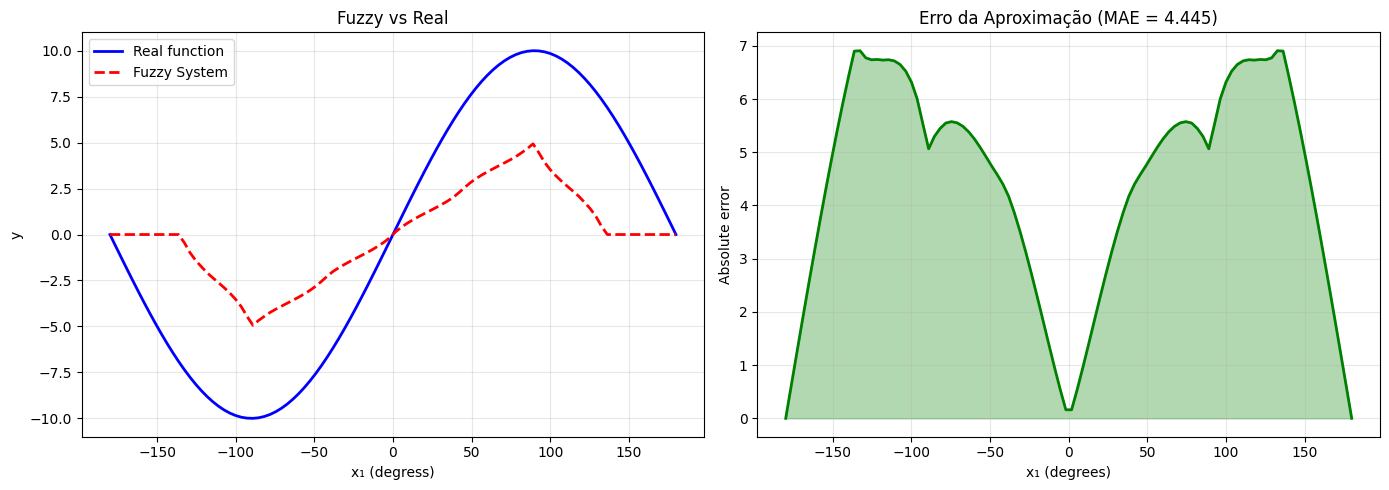





{'mae': np.float64(4.445150433160939), 'rmse': np.float64(4.886293355050017), 'max_error': np.float64(6.90819837941642), 'points': array([-180.        , -176.36363636, -172.72727273, -169.09090909,
       -165.45454545, -161.81818182, -158.18181818, -154.54545455,
       -150.90909091, -147.27272727, -143.63636364, -140.        ,
       -136.36363636, -132.72727273, -129.09090909, -125.45454545,
       -121.81818182, -118.18181818, -114.54545455, -110.90909091,
       -107.27272727, -103.63636364, -100.        ,  -96.36363636,
        -92.72727273,  -89.09090909,  -85.45454545,  -81.81818182,
        -78.18181818,  -74.54545455,  -70.90909091,  -67.27272727,
        -63.63636364,  -60.        ,  -56.36363636,  -52.72727273,
        -49.09090909,  -45.45454545,  -41.81818182,  -38.18181818,
        -34.54545455,  -30.90909091,  -27.27272727,  -23.63636364,
        -20.        ,  -16.36363636,  -12.72727273,   -9.09090909,
         -5.45454545,   -1.81818182,    1.81818182,    5.4545

In [9]:
system = FuzzySystem()
system.building_membership_matrix(operator='min')
result = system.checking_errors(real_function)

system.plot_comparison(real_function)
print("\n")
print(system)
print("\n")
print(result)